# Sentiment analysis with keras
## Data description: A csv with reviews of restaurants from Tripadvisor. 
## There are a number of problems with the data, for example the review score is expressed as "4 of 5 bubbles" instead of just "4"

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))

['glove-global-vectors-for-word-representation', 'londonbased-restaurants-reviews-on-tripadvisor']


In [2]:
raw = pd.read_csv("../input/londonbased-restaurants-reviews-on-tripadvisor/tripadvisor_co_uk-travel_restaurant_reviews_sample.csv")

## Let's have a quick check at the data

In [3]:
raw.head()

,uniq_id,url,restaurant_id,restaurant_location,name,category,title,review_date,review_text,author,author_url,location,rating,food,value,service,visited_on
0,76b689f7956f0dc70bda40450e0bae1c,https://www.tripadvisor.co.uk/ShowUserReviews-...,g186338-d1988022,London,Balans Soho Society,Review of restaurants,“Breakfast at balans a must ! ”,2015-07-28,Fantastic as usual with friendly service ... W...,richard5003,https://www.tripadvisor.co.uk/members/richard5003,NaN,5 of 5 bubbles,NaN,NaN,NaN,June 2015
1,0712b79accc38942797b4ca27eabf98d,https://www.tripadvisor.co.uk/ShowUserReviews-...,g186338-d5600132,London,Duke of York,Review of restaurants,“Ok for a quick pint”,2014-06-17,"Average pub, where you can be serve quickly. T...",pierre l,https://www.tripadvisor.co.uk/members/714pierrel,"London, United Kingdom",3 of 5 bubbles,3 of 5 bubbles,4 of 5 bubbles,3 of 5 bubbles,May 2014
2,eb50da7d57e9cd6cdb84220cf09dc70b,https://www.tripadvisor.co.uk/ShowUserReviews-...,g186338-d2257005,London,Dawat Restaurant,Review of restaurants,“Good Pakistani food”,2016-12-19,Personally my favourite Pakistani restaurant i...,Ehsiii,https://www.tripadvisor.co.uk/members/Ehsiii,NaN,4 of 5 bubbles,NaN,NaN,NaN,December 2016
3,b29e2213a0f62d29ef9bfd3aeb2b18ef,https://www.tripadvisor.co.uk/ShowUserReviews-...,g186338-d1123250,London,Gourmet Burger Kitchen Ealing,Review of restaurants,“Great Burgers”,2016-02-18,For a while now I’ve been dreaming of that Bur...,Gary B,https://www.tripadvisor.co.uk/members/252garyb,"London, England, United Kingdom",4 of 5 bubbles,4 of 5 bubbles,4 of 5 bubbles,4 of 5 bubbles,February 2016
4,994256feb6c70231ebf5ae0ec919473c,https://www.tripadvisor.co.uk/ShowUserReviews-...,g186338-d2689314,London,Lingo,Review of restaurants,“Good Japanese Food in Soho”,2014-12-22,It's close to Regent Street and its tucked awa...,benbecks23,https://www.tripadvisor.co.uk/members/benbecks23,"Singapore, Singapore",4 of 5 bubbles,4 of 5 bubbles,4 of 5 bubbles,5 of 5 bubbles,December 2014


## There are a lot of columns there, this is a very comprehensive dataset, but in order to keep things simple, lets just use the review and the score

In [4]:
cleaned = raw[["review_text", "rating"]]

In [5]:
cleaned.head()

,review_text,rating
0,Fantastic as usual with friendly service ... W...,5 of 5 bubbles
1,"Average pub, where you can be serve quickly. T...",3 of 5 bubbles
2,Personally my favourite Pakistani restaurant i...,4 of 5 bubbles
3,For a while now I’ve been dreaming of that Bur...,4 of 5 bubbles
4,It's close to Regent Street and its tucked awa...,4 of 5 bubbles


In [6]:
set(cleaned["rating"])

{nan,
 '4.0 of 5 bubbles',
 'September 2015',
 '5 of 5 bubbles',
 '3 of 5 bubbles',
 '3 of 5 stars',
 '1 of 5 bubbles',
 '2.0 of 5 bubbles',
 '4 of 5 stars',
 '3.0 of 5 bubbles',
 '1.0 of 5 bubbles',
 'April 2015',
 '5.0 of 5 bubbles',
 '4 of 5 bubbles',
 '2 of 5 bubbles',
 '2 of 5 stars',
 '1 of 5 stars',
 '5 of 5 stars'}

## The first thing is to convert the "N of 5 bubbles" into just "N" we will use the apply function for that, notice that some rows do not seem to follow that, we have some funny values such as "April 2015 or "September 2015" so our function will have to take care of that

In [7]:
def clean(raw_data):
    as_string = str(raw_data["rating"])
    try:
        return int(as_string[0]) # Our number of bubbles is simply the first character
    except:
        # Some values cannot be converted... in which case set to -1 and we will remove them later
        return -1

cleaned["y"] = cleaned.apply(clean, axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
cleaned.head()

,review_text,rating,y
0,Fantastic as usual with friendly service ... W...,5 of 5 bubbles,5
1,"Average pub, where you can be serve quickly. T...",3 of 5 bubbles,3
2,Personally my favourite Pakistani restaurant i...,4 of 5 bubbles,4
3,For a while now I’ve been dreaming of that Bur...,4 of 5 bubbles,4
4,It's close to Regent Street and its tucked awa...,4 of 5 bubbles,4


## Lets take a closer look at the text

In [9]:
print(cleaned["review_text"][0], "\n")
print(cleaned["review_text"][1], "\n")
print(cleaned["review_text"][2])

Fantastic as usual with friendly service ... We always head here after nursing the usual high cost city hangover - but don't worry at Ballans you will never feel ripped off ! 3 types of eggs to choose from all cooked to perfection with a lovely sausage , toast , beans and small pieces of hash browns take a beer on the side and enjoy your trip to balans don't even look another way in the Westfield this is THE place to go !!!! Come on 

Average pub, where you can be serve quickly. Th only down side will be the crowd around the some of the staff. You do't fell very welcome there 

Personally my favourite Pakistani restaurant in tooting. Good food, good meat quality and a reasonable price.


## As we can see, we are going to need to clean our data (I know... booooring) but this is an important step, if you feed crappy data to a model you will get... well a crappy model. So I know we all want to jump into defining the neural network model, but this has to be done first :)

## We will need to 

1. Make everything lower case.
2. Get rid of pretty much everything that is not a a letter.

In [10]:
import re
def clean_text(df):
    text = str(df["review_text"])
    text = text.lower()
    text = re.sub("[^a-z\s]", "", text)
    return text

cleaned["review_text"] = cleaned.apply(clean_text, axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
print(cleaned["review_text"][0], "\n")
print(cleaned["review_text"][1], "\n")
print(cleaned["review_text"][2], "\n")

fantastic as usual with friendly service  we always head here after nursing the usual high cost city hangover  but dont worry at ballans you will never feel ripped off   types of eggs to choose from all cooked to perfection with a lovely sausage  toast  beans and small pieces of hash browns take a beer on the side and enjoy your trip to balans dont even look another way in the westfield this is the place to go  come on 

average pub where you can be serve quickly th only down side will be the crowd around the some of the staff you dot fell very welcome there 

personally my favourite pakistani restaurant in tooting good food good meat quality and a reasonable price 



## Things look more clear now... as we want to keep this simple, lets just rename our columns to X and y

In [12]:
del cleaned["rating"]
cleaned.columns = ["X", "y"]

In [13]:
cleaned.head()

,X,y
0,fantastic as usual with friendly service we a...,5
1,average pub where you can be serve quickly th ...,3
2,personally my favourite pakistani restaurant i...,4
3,for a while now ive been dreaming of that burg...,4
4,its close to regent street and its tucked away...,4


## Remember that we used a score = -1 to those columns we could not convert, it is time to drop them now

In [14]:
cleaned = cleaned[cleaned["y"] > 0]
cleaned.head()

,X,y
0,fantastic as usual with friendly service we a...,5
1,average pub where you can be serve quickly th ...,3
2,personally my favourite pakistani restaurant i...,4
3,for a while now ive been dreaming of that burg...,4
4,its close to regent street and its tucked away...,4


## Next, It would be interesting to know how big are our reviews... ultimately we will need to feed to our neural network a fixed text size so we might as well understand the data a big more

In [15]:
cleaned["review_size"] = cleaned["X"].str.count(" ")
cleaned["review_size"].describe()

count    17223.000000
mean        86.025083
std         75.233422
min          1.000000
25%         37.000000
50%         64.000000
75%        109.000000
max       1210.000000
Name: review_size, dtype: float64

## This is relevant information, we seem to have reviews with very few words... lets plot it

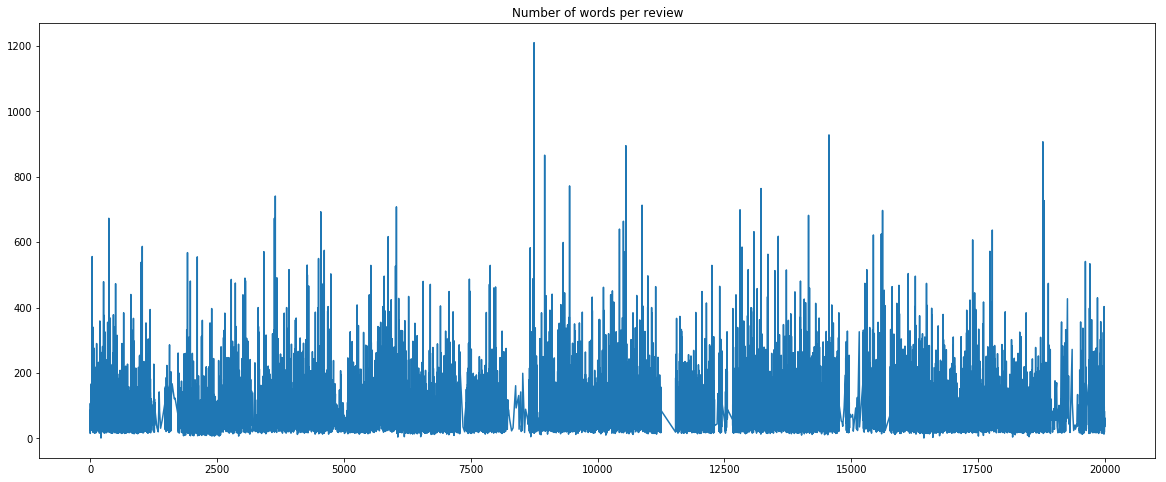

In [16]:
cleaned["review_size"].plot(title="Number of words per review", figsize=(20, 8))

## In the chart above we can see that some reviews have very few words... lets get rid of any review with less than 50 words.

In [17]:
cleaned = cleaned[cleaned["review_size"] >= 50]
cleaned["review_size"].describe()

count    10779.000000
mean       118.382874
std         78.659133
min         50.000000
25%         68.000000
50%         94.000000
75%        140.000000
max       1210.000000
Name: review_size, dtype: float64

## We got rid of quite a lot of reviews, now lets analyze the scores

## And lets do a super quick look at our data

In [18]:
del cleaned["review_size"]
cleaned.describe()

,y
count,10779.000000
mean,3.855645
std,1.249731
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


## Here comes the first "surprise" it seems that people are very generous when giving out reviews, the mean is over 4 out of 5, lets plot them to get a better idea

In [19]:
scores = cleaned.groupby(["y"]).agg("count")

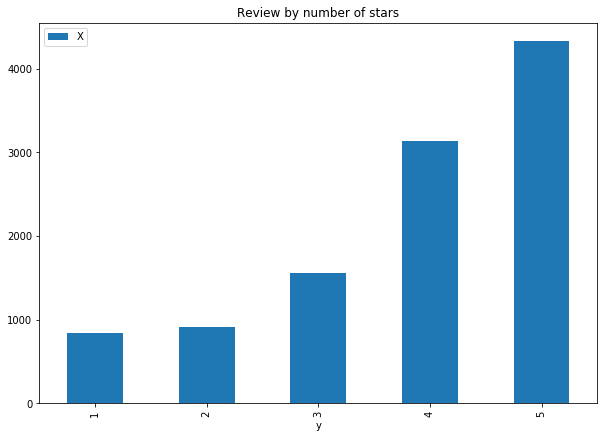

In [20]:
scores.plot(kind='bar', title="Review by number of stars", figsize=(10, 7))

## As we mentioned before, we have an interesting distribution, most of people label restaurants with 4 or 5 stars... it is something to take into account, we are dealing with a n asymmetric distribution

## Now we are going to prepare the text, lets get our hands dirty

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## We are going to tokenize the whole corpus, this means to assign a numbe (id) to each word, so that we will have a list of ints instead of a list of words.

In [22]:
# Lets tokenize the works, we will only keep the 20.000 most common words
VOCAB_SIZE=20000
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(cleaned["X"])
sequences = tokenizer.texts_to_sequences(cleaned["X"])
print("Number of sequences", len(sequences))

Number of sequences 10779


In [23]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print("Index for 'great' is ", word_index["great"])

Found 33835 unique tokens.
Index for 'great' is  39


## The next thing is to convert the text to sequences of the same size. Remeber that ultimately a neural network works with matrices, the number of rows is of course the number of reviews, what about the number of columns? in our case we will define a variable ```SEQUENCE_SIZE``` to determine what is that value.

## The reviews with less than ```SEQUENCE_SIZE``` words will simply add zeros to the end, and the reviews that are too big will be truncated

In [24]:
SEQUENCE_SIZE=120
data = pad_sequences(sequences, maxlen=SEQUENCE_SIZE)
print("Our padded data has a shape of ", data.shape)

Our padded data has a shape of  (10779, 120)


In [25]:
labels = cleaned["y"]
# Normalize the labels to values between 0 and 1, this can be done by simply dividing by 5, we will later need to multiply our predictions by 5
labels = labels / 5


In [26]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (10779, 120)
Shape of label tensor: (10779,)


## Time to do train and test data split, we will use 70% of data for training

In [27]:
validation_split = int(data.shape[0] * 0.7)
X_train = data[0: validation_split]
y_train = labels[0: validation_split]

X_test = data[validation_split:]
y_test = labels[validation_split:]

In [28]:
print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_test", X_test.shape, "y_test", y_test.shape)

X_train (7545, 120) y_train (7545,)
X_test (3234, 120) y_test (3234,)


## Lets play now: We are going to build a simple network with just an embedding layer, an LSTM (Long Short Term Memory) layer and the output one, notice that this is a REGRESSION problem, not a CLASSIFICATION one, we are not interested on determining whether the review is a 1 or 2 or 3... 5, in our case the output will be a number, for example 3.687, the metric used to determine how good we are going will be the mean square distance

## It is important to understand why this will be treated as a regression problem: Imagine we have a given review and its label is 4 stars, now lets imagine we have two different models

1.** model A predicts a label of 1.**
2. ** model B predicts a label of 5.**

## Which model is better? our intuition obviously goes for model B and in this case this is correct, if we measure the error as the absolute difference between our prediction and the actual prediction, model A has an error of 3 (4-1) and model B has an error of 1 (4-1).

## What occurs if we treat this as a classification problem? Well, in that case the error would depend on the cross entropy, which will penalize equally models A and B, however if we use the mean average error or the mean squared error, we will have more accurate predictions.

## Let's quickly review the formula for mean average error: 

![ ](https://wikimedia.org/api/rest_v1/media/math/render/svg/3ef87b78a9af65e308cf4aa9acf6f203efbdeded)

## Now do not get scared, the SUM symbol represents simply a loop, Y represents the actual value and X represents each of our predictions, N is just the number of samples


In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM, TimeDistributed, Embedding, Dropout
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=SEQUENCE_SIZE))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(1, activation="linear"))

In [30]:
from keras.optimizers import RMSprop

rmsprop = RMSprop(lr=0.0001)

model.compile(loss='mae', optimizer=rmsprop)
for layer in model.layers:
    print("Layer", layer.name, "Is trainable? ==>", layer.trainable)
model.summary()

Layer embedding_1 Is trainable? ==> True
Layer dropout_1 Is trainable? ==> True
Layer lstm_1 Is trainable? ==> True
Layer dropout_2 Is trainable? ==> True
Layer dense_1 Is trainable? ==> True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 100)          2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,365,825
Trainable params: 2,365,825
Non-trainable params: 0
______

### Aaaand, time to train now

In [31]:
history = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.3)

Train on 5281 samples, validate on 2264 samples
Epoch 1/8
5281/5281 [==============================] - 42s 8ms/step - loss: 0.2721 - val_loss: 0.3036
Epoch 2/8
5281/5281 [==============================] - 38s 7ms/step - loss: 0.1901 - val_loss: 0.4965
Epoch 3/8
5281/5281 [==============================] - 38s 7ms/step - loss: 0.1685 - val_loss: 0.2806
Epoch 4/8
5281/5281 [==============================] - 39s 7ms/step - loss: 0.1580 - val_loss: 0.2143
Epoch 5/8
5281/5281 [==============================] - 38s 7ms/step - loss: 0.1498 - val_loss: 0.2355
Epoch 6/8
5281/5281 [==============================] - 38s 7ms/step - loss: 0.1421 - val_loss: 0.2420
Epoch 7/8
5281/5281 [==============================] - 38s 7ms/step - loss: 0.1368 - val_loss: 0.2110
Epoch 8/8
5281/5281 [==============================] - 38s 7ms/step - loss: 0.1315 - val_loss: 0.2832


### After training, it is always fundamental to understand how things went, I have learned (the hard way) to always plot the learning curves, so lets do that

In [32]:
model_history = pd.DataFrame.from_dict(history.history)
model_history

,loss,val_loss
0,0.272101,0.303646
1,0.190124,0.496502
2,0.168536,0.280551
3,0.158037,0.214313
4,0.149772,0.235451
5,0.142062,0.241961
6,0.136764,0.211038
7,0.131471,0.283194


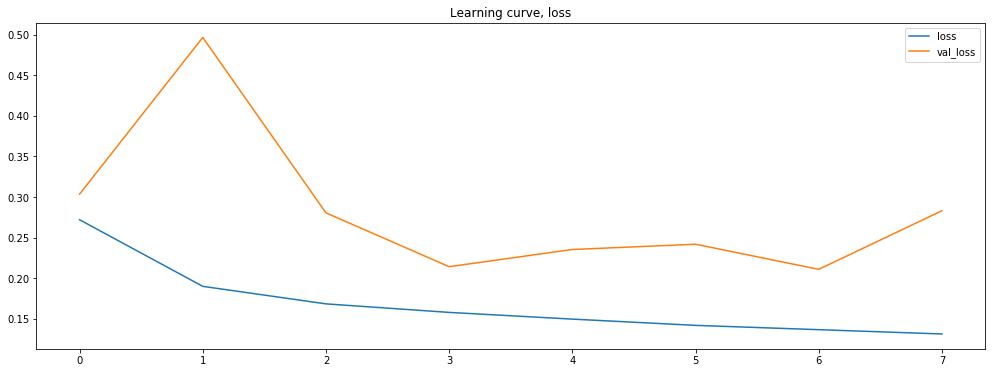

In [33]:
model_history[["loss", "val_loss"]].plot(title="Learning curve, loss", figsize=(17, 6))

In [34]:
model.evaluate(X_test, y_test)

3234/3234 [==============================] - 6s 2ms/step


0.29166099071576407

## Lets make one prediction with our model

In [35]:
five_star_review = """My wife and I were here for dinner last night, what an amazing experience. Entree were crab and pork, both amazing dishes full of flavor. I understand what others have said in their reviews re: portion size, however; the skill involved in making these dishes deserves somebody to savour it and not rush it. Mains were the wagyu, and the lamb. Despite both being meat dishes, I couldn't say which one I liked more despite trying both as they were so different. Full of flavours, expertly cooked. The wagyu was tender and the flavours amazing, the lamb was perfect and all the accompaniments were expertly suited. Dessert was a chocolate mousse, you only need a little bit because it's so rich. The whole experience was amazing. A special mention to Ashe who had the most amazing/funny/professional table manner when serving, he's a true asset to the establishment. Unfortunately cash flow has been tight this month for good reasons, but it meant we weren't able to tip after receiving the bill. Despite this, we hope to return again and will make up for our evening last night on our next visit."""
three_star_review = """We had heard good things about this place, but it has let us down twice. The first time it was busy and we gave up waiting for service after about 20 minutes. So, yesterday we tried again with 6 friends who were visiting the 'Mountains.' Sadly, the waiter seemed unaware of almost anything on the menu, got four orders wrong and failed to even place one order at all! He then went home and another server had to deal with the mistakes. Four of us were disappointed with the food and the other four thought it was just okay. The location is great but this cafe needs a real shake-up."""
one_star_review = """The location was spectacular, the fireplace created a beautiful ambiance on a winters day. However the food was a lot to be desired. My friend had been previously with her husband and enjoyed the meals, however what we got was disgusting! We ordered sausages from the local butcher with polenta....well Coles cheap beef sausages are a lot tastier and moist, they looked like they boiled them and put them on a plate, absolutely no grill marks, the polenta was so dry I gagged. My other friend ordered their homemade pie that was stuck in a microwave oven to be heated and ended with soggy pastry. Sorry but definitely need someone new in the kitchen. The staff, well the first lady that took us to our table was lovely, but the second person we ordered our coffees with was so upset that we were going to delay her from leaving work on time. Definitely won't be returning or recomending!"""

texts = [five_star_review, three_star_review, one_star_review]

text_data = pd.DataFrame(data=texts, columns=["review_text"])
text_data["review_text"] = text_data.apply(clean_text, axis=1)
sequences_test = tokenizer.texts_to_sequences(text_data["review_text"])
to_predict = pad_sequences(sequences_test, maxlen=SEQUENCE_SIZE)

output = model.predict(to_predict, verbose=False)
print("Predicted", output*5)

Predicted [[5.3880353]
 [3.929361 ]
 [4.0892296]]


## No too bad, our system is actually learning and our validation and training lines are similar, now the question is, can we do better?

## And of course the answer is YES!! 

## Instead of training the embeddings ourselves, lets use a trained result already, fortunately someone spent a lot of time training the whole wikipedia and providing embeddings of either 50, 100 or 200 dimensions, in our case we will use the 100 dimensions one

In [36]:
print(os.listdir("../input"))
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join("../input/glove-global-vectors-for-word-representation", 'glove.6B.100d.txt'))
count = 0
for line in f:
    count += 1
    if count % 100000 == 0:
        print(count, "vectors so far...")
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

['glove-global-vectors-for-word-representation', 'londonbased-restaurants-reviews-on-tripadvisor']
Indexing word vectors.
100000 vectors so far...
200000 vectors so far...
300000 vectors so far...
400000 vectors so far...
Found 400000 word vectors.


In [37]:
print("Word 'great' has a vector like this \n", embeddings_index["great"])

Word 'great' has a vector like this 
 [-0.013786   0.38216    0.53236    0.15261   -0.29694   -0.20558
 -0.41846   -0.58437   -0.77355   -0.87866   -0.37858   -0.18516
 -0.128     -0.20584   -0.22925   -0.42599    0.3725     0.26077
 -1.0702     0.62916   -0.091469   0.70348   -0.4973    -0.77691
  0.66045    0.09465   -0.44893    0.018917   0.33146   -0.35022
 -0.35789    0.030313   0.22253   -0.23236   -0.19719   -0.0053125
 -0.25848    0.58081   -0.10705   -0.17845   -0.16206    0.087086
  0.63029   -0.76649    0.51619    0.14073    1.019     -0.43136
  0.46138   -0.43585   -0.47568    0.19226    0.36065    0.78987
  0.088945  -2.7814    -0.15366    0.01015    1.1798     0.15168
 -0.050112   1.2626    -0.77527    0.36031    0.95761   -0.11385
  0.28035   -0.02591    0.31246   -0.15424    0.3778    -0.13599
  0.2946    -0.31579    0.42943    0.086969   0.019169  -0.27242
 -0.31696    0.37327    0.61997    0.13889    0.17188    0.30363
 -1.2776     0.044423  -0.52736   -0.88536   -0.1

In [38]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print("Size of the embedding matrix is ", embedding_matrix.shape)

Size of the embedding matrix is  (33836, 100)


In [39]:
embedding_layer = Embedding(len(word_index) + 1,  # Input dim
                            EMBEDDING_DIM,  # Output dim
                            weights=[embedding_matrix],
                            input_length=SEQUENCE_SIZE,  
                            trainable=False)

# This layer will take an input of 
#           BatchSize x SEQUENCE_SIZE
# And the output will be
#           None, SEQUENCE_LENGTH, 100


In [40]:
from keras.layers import Flatten, TimeDistributed
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add((Dense(1, activation='linear')))

In [41]:
rmsprop = RMSprop(lr=0.001)

model.compile(loss='mae', optimizer=rmsprop)

for layer in model.layers:
    print("Layer", layer.name, "Is trainable? ==>", layer.trainable)
model.summary()


Layer embedding_2 Is trainable? ==> False
Layer dropout_3 Is trainable? ==> True
Layer lstm_2 Is trainable? ==> True
Layer dropout_4 Is trainable? ==> True
Layer dense_2 Is trainable? ==> True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 100)          3383600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,500,977
Trainable params: 117,377
Non-trainable params: 3,383,600

In [42]:
history = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.3)

Train on 5281 samples, validate on 2264 samples
Epoch 1/8
5281/5281 [==============================] - 37s 7ms/step - loss: 0.2470 - val_loss: 0.2120
Epoch 2/8
5281/5281 [==============================] - 36s 7ms/step - loss: 0.1953 - val_loss: 0.2393
Epoch 3/8
5281/5281 [==============================] - 36s 7ms/step - loss: 0.1809 - val_loss: 0.2516
Epoch 4/8
5281/5281 [==============================] - 37s 7ms/step - loss: 0.1658 - val_loss: 0.1720
Epoch 5/8
5281/5281 [==============================] - 35s 7ms/step - loss: 0.1575 - val_loss: 0.1547
Epoch 6/8
5281/5281 [==============================] - 37s 7ms/step - loss: 0.1520 - val_loss: 0.2167
Epoch 7/8
5281/5281 [==============================] - 36s 7ms/step - loss: 0.1459 - val_loss: 0.1765
Epoch 8/8
5281/5281 [==============================] - 35s 7ms/step - loss: 0.1439 - val_loss: 0.1402


In [43]:
model_history = pd.DataFrame.from_dict(history.history)
model_history

,loss,val_loss
0,0.246990,0.212019
1,0.195281,0.239315
2,0.180861,0.251642
3,0.165828,0.172006
4,0.157539,0.154672
5,0.151986,0.216714
6,0.145942,0.176483
7,0.143910,0.140172


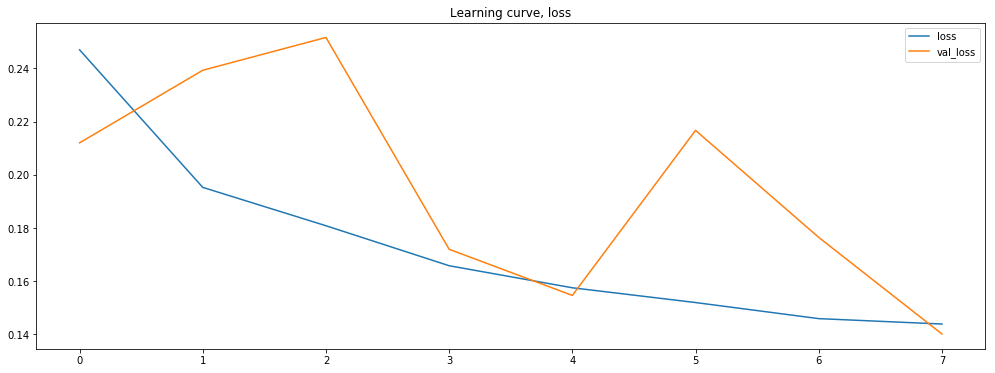

In [44]:
model_history[["loss", "val_loss"]][model_history["loss"]< 3].plot(title="Learning curve, loss", figsize=(17, 6))

In [45]:
output = model.predict(to_predict, verbose=False)
print("Predicted", output*5)

Predicted [[4.575333 ]
 [2.5785663]
 [2.8596246]]


In [46]:
model.evaluate(X_test, y_test)

3234/3234 [==============================] - 5s 2ms/step


0.14784623195008872